# Calculate lateralized ERPs

In this notebook we calculate and evaluate the CDA. Further, we run some
control analyses to check whether the selection of our ROI or the time-window
played a crucial role for the observed results.

In [1]:
# import os
import os.path as op
from pathlib import Path
import numpy as np
import scipy
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import seaborn as sns
import mne

from scipy import stats
from mne.stats import permutation_cluster_1samp_test

from library import helpers, config


Study path is set to: /raven/ptmp/fklotzsche/Experiments/vMemEcc


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
def get_psds(epo_part, sub_list,  plt_dict, data_type="collapsed"):
    evokeds = defaultdict(list)
    for sub in sub_list: 
        if data_type not in ["difference", "collapsed"]:
            raise ValueError(f"Invalid data type '{data_type}'. Has to be either 'difference' or 'collapsed'.")
        subID = 'VME_S%02d' % sub
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                        data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        epos.pick_channels(plt_dict['picks'])
        # epos.crop(plt_dict[epo_part]['xmin'], plt_dict[epo_part]['xmax'])
def ci(vec, alpha=0.95):
    return scipy.stats.t.interval(
        confidence=alpha,
        df=len(vec) - 1,
        loc=np.mean(vec),
        scale=np.std(vec, ddof=1) / np.sqrt(len(vec)),
    )


def get_cmci(
    normalized_vals: np.array, n_factorlevels: int, alpha: float = 0.05
) -> tuple:
    """Calculate Cosineau-Morey CIs

    Parameters
    ----------
    normalized_vals : numpy.array
        Vector of samples of 1 experimental condition.
    n_factorlevels : int
        Number of factor levels across all within-factors.
    alpha : float, optional
        Alpha level, by default 0.05:float

    Returns
    -------
    tuple
        Boundaries of the CI
    """
    mean = np.mean(normalized_vals)

    morey_factor = np.sqrt(n_factorlevels / (n_factorlevels - 1))
    tval = scipy.stats.t.ppf(1 - (alpha / 2), len(normalized_vals) - 1)

    sem = np.std(normalized_vals, ddof=1) / np.sqrt(len(normalized_vals))

    ci = tval * morey_factor * sem

    lower = mean - ci
    upper = mean + ci

    return (lower, upper)

def get_evokeds_dict(sub_list, epo_part, plt_dict, data_type="difference"):
    evokeds = defaultdict(list)
    for sub in sub_list: 
        if data_type not in ["difference", "collapsed"]:
            raise ValueError(f"Invalid data type '{data_type}'. Has to be either 'difference' or 'collapsed'.")
        subID = 'VME_S%02d' % sub
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                        data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        if plt_dict['picks'] != None:
            epos.pick_channels(plt_dict['picks'])
        epos.crop(plt_dict[epo_part]['xmin'], plt_dict[epo_part]['xmax'])
        event_dict = helpers.get_event_dict(epos.event_id)
        for load in ['LoadLow', 'LoadHigh']:
            evoked_load = epos[event_dict[load]].copy().average()   
            evokeds[load].append(evoked_load)
            for ecc in ['EccS', 'EccM', 'EccL']:
                if load == 'LoadLow':  # we don't want to do this twice
                    evoked_ecc = epos[event_dict[ecc]].copy().average()  
                    evokeds[ecc].append(evoked_ecc)
                # Interaction:
                evoked_interac = epos[event_dict[load]][event_dict[ecc]].copy()
                evoked_interac = evoked_interac.average()
                evokeds[load+ecc].append(evoked_interac)
        evokeds['all'].append(epos.copy().average())
    return(evokeds)



def plot_main_cda(ax, evokeds):
    # Plot main curve CDA:
    label_dict = dict()
    label_dict['CDA: Contra - Ipsi'] = evokeds['all']

    mne.viz.plot_compare_evokeds(label_dict, 
                                combine='mean', 
                                #colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=0.68,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )

    ax.legend(loc=1, prop={'size': 9})
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.set_aspect(0.25)
    ax.set_title('')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)
    plt.xticks(fontsize=9)


def run_cbp_test(data, n_perm=1000, p_initial=0.05, p_thresh=0.05, tail=0.,
                 adjacency=None):
    """Run a cluster-based permutation test: paired t-test. 
    
    Parameters
    ----------
    data : ndarray, shape (n_observations, times)
        2d array with difference between conditions (n_observations x timepoints)
    n_perm : int
        Number of permutations, default: 1000
    p_initial : int
        Initial threshold (1st round of cbp test), default: 0.05
    p_thresh : int
        Familywise p value (2nd round of cbp test), default: 0.05
    tail : int
        0: two-sided test (default); -1: left-sided; 1: right-sided

    Returns
    -------
    T_obs : array, shape (n_tests,)
        T-statistic observed for all variables.
    clusters : list
        list of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        P-value for each cluster.

    Notes
    -------
    For details check documentation of `mne.stats.permutation_cluster_1samp_test`.
    """
    # number of permutations to run
    n_permutations = n_perm 
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = adjacency

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.n_jobs,
        verbose=True,
        tail=tail,
        step_down_p=0.05,
        adjacency=adjacency,
        n_permutations=n_permutations,
        seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)

def find_largest_cluster_times(clusters, times): 
    #TODO: write DOCSTR or remove
    cl_lengths = [c[0].stop - c[0].start for c in clusters]
    idx_max_length = np.argmax(cl_lengths)
    return (times[clusters[idx_max_length]], idx_max_length)


def plot_cbp_result_cda(ax, T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full):
    """Plot the results of the CBP test by plotting the T values over time,
    highlighting significant clusters.

    Paramteters
    -------
    ax : Axes instance
        Axes object to plot into.
    clusters : list
        Output of `run_cbp_test`.
        List of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        Output of `run_cbp_test`.
        P-value for each cluster.
    p_thresh : int
        Familywise p value (2nd round of cbp test) used in the underlying CBP test
    times_cbp : array, shape (srate * duration retention interval,)
        Sample times.
    times_full : array, shape (srate * duration full trial,)
        Sample times.
    """
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(times_cbp[c[0]], times_cbp[c[-1]],
                            color='r', alpha=0.3)
    ax.plot(times_cbp, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
           ylim=y_max,
           xlim=times_full[np.array([0,-1])])
    plt.tight_layout(pad=0.0)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    # ax.set_aspect('auto', adjustable='datalim')
    # ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)

                          
def plot_main_effect(evokeds, conds, picks, ax, sign_cluster=None, ci_func=95, show_legend=False):
    """Plot the main effect of Memory Load on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.
    """
    
    res = plot_compare(evokeds, conds, ax, ci_func, show_legend)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim((-1.5, 1.5))
    ax.set_xlim((-0.2, 2.3))

    ax.axhline(0, color='k', linewidth=1., zorder=-2)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    for x in [0, 0.2, 2.2]:
        ax.axvline(x, linestyle='--', color='k',
                   linewidth=1., zorder=-2)
    
    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color='red', alpha=0.1)
    
    if show_legend:
        handles, _ = ax.get_legend_handles_labels() 
        ax.legend(loc=1, prop={'size': config.plt_label_size}, 
                title='', ncol=3,
                bbox_to_anchor =(1.0, 1.25),
                handles=handles, 
                labels=[config.labels[c] for c in conds])

    ax.set_title('')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)', fontname=config.plt_fontname)
    ax.set_xlabel('Time (s)')

    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)
                          

def plot_compare(evokeds, conds, ax, ci_func, show_legend=True):
    n_subs = len(evokeds[conds[0]])
    dfs = []
    for cond in conds:
        for i in range(n_subs):
            evo = evokeds[cond][i]
            df = pd.DataFrame(evo.data *1e6, columns=evo.times, index=evo.ch_names)
            df['condition'] = cond
            # df = df.reset_index()
            dfs.append(df)
    dd = (pd.concat(dfs, axis=0, keys=list(range(n_subs)) * len(conds))
            .set_index(['condition'], append=True))
    dd.index.names = ['sub_nr', 'chan', 'condition']
    
    df_plot = (dd.groupby(['sub_nr', 'condition'])
                .mean()
                .reset_index()
                .melt(var_name='time', value_name='y', 
                    id_vars=['condition', 'sub_nr']))

    # Normalize the data according to Cosineau (2005):
    grav = df_plot.copy().set_index(['time', 'sub_nr']).groupby('time').mean()  
    grav.columns = ['grandavg']
    subavg = df_plot.copy().groupby(['time', 'sub_nr']).mean()
    subavg.columns = ['subavg']
    adj_factor = grav.join(subavg)
    adj_factor['adj_factor'] = adj_factor.grandavg - adj_factor.subavg
    df_plot = df_plot.set_index(['time', 'sub_nr']).join(adj_factor)
    df_plot['y_corrected'] = df_plot.y + df_plot.adj_factor
    
    sns.lineplot(
        data=df_plot,
        x='time',
        y='y_corrected',
        hue='condition',
        hue_order=conds,
        errorbar=ci_func, #cmci adds the correction suggested by Morey (2008)
        ax=ax,
        palette=config.colors,
        n_boot=1000, #unused for cmci
        linewidth=0.5,
        legend=show_legend,
        err_kws={"alpha": .3, "clip_on": False})



def plot_interaction_eff(evokeds, picks, axs, ci_func, show_ecc=False):
    """Plot the effect of Memory Load on the lateralized ERP split up by Eccentricity condition.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    """
    for ecc, tt, idx, leg in zip(['EccS', 'EccM', 'EccL'], 
                            ['Ecc = 4°', 'Ecc = 9°', 'Ecc = 14°'], 
                            [0, 1, 2], 
                            [1, False, False]):
        conds = ['LoadLow', 'LoadHigh']
        evokeds_sel = {c: evokeds[c + ecc] for c in conds}
        res = plot_compare(evokeds_sel, conds, axs[idx], ci_func, show_legend=leg)

    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])
    axs[0].xaxis.label.set_visible(False)
    axs[1].xaxis.label.set_visible(False)
    axs[0].yaxis.label.set_visible(False)
    axs[2].yaxis.label.set_visible(False)
    handles, _ = axs[0].get_legend_handles_labels() 
    axs[0].legend(loc=1, prop={'size': 6},
                  handles=handles,
                  labels=[config.labels[c] for c in ['LoadLow', 'LoadHigh']])

    for axx, ecc in zip(axs, ['4', '9', '14']):
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)

        axx.set_ylim((-1.5, 1.5))
        axx.set_xlim((-0.2, 2.3))

        axx.set_ylabel('CDA amplitude (' + chr(956) + 'V)', fontname=config.plt_fontname)
        axx.set_xlabel('Time (s)')

        axx.axhline(0, color='k', linewidth=1., zorder=-2)
        axx.axvspan(0, 0.2, color='grey', alpha=0.3)
        axx.axvspan(2.2, 2.3, color='grey', alpha=0.3)
        for x in [0, 0.2, 2.2]:
            axx.axvline(x, linestyle='--', color='k',
                    linewidth=1., zorder=-2)
        #axx.set_aspect(0.33)
        axx.set_title('')
        at = AnchoredText(" Ecc.: " + ecc + "° ",
                            loc='lower left', prop=dict(size=9), frameon=True,
                            bbox_to_anchor=(-0.01, 0.97),
                            bbox_transform=axx.transAxes)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        if show_ecc:
            axx.add_artist(at)

        
def allsubjects_mean_amp_to_df(sub_list, epo_part, channels, t_min, t_max, component_name, data_type="difference"):
    mean_amp_df = pd.DataFrame()
    for sub in sub_list:
        subID = 'VME_S%02d' % sub
        print(F"Reading {subID}...")
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos_ = mne.read_epochs(fname, verbose=False)
        df_ = mean_amp_to_df(epos_, subID, channels, t_min, t_max, component_name)
        # assert pd.concat([mean_amp_df, df_]).equals(mean_amp_df.append(df_))
        mean_amp_df = pd.concat([mean_amp_df, df_])
    
    return mean_amp_df
        
        
        
# TODO: docu
def mean_amp_to_df(epos, subID, channels, t_min, t_max, component_name):
    """Takes the Epochs of one subject, calculates the mean amplitude in a given ROI and time window per 
    trial, and returns a data frame."    
    """
    
    epos.pick_channels(channels)
    epos.crop(t_min, t_max)
    
    # Keep volatge in V for backwards compatibility:
    scalings = {'eeg': 1}
    df = epos.to_data_frame(scalings=scalings)

    df['signal_roi'] = df[channels].mean(axis=1)
    dict_load = {v: k for k in config.event_dict for v in config.event_dict[k] if "Load" in k}
    dict_ecc = {v: k for k in config.event_dict for v in config.event_dict[k] if "Ecc" in k}
    df['c_Ecc'] = df['condition'].replace(dict_ecc)
    df['c_StimN'] = df['condition'].replace(dict_load)
    df2 = df.groupby(['epoch', 'c_Ecc', 'c_StimN']).mean().reset_index()
    df2["trial_num"] = df2["epoch"] + 1
    df2["subID"] = subID
    colname = f"{component_name.lower()}_mean_amp"
    df2[colname] = df2["signal_roi"]
    df3 = df2[["subID", "c_StimN", "c_Ecc",  colname, "trial_num"]]
    return df3

In [4]:

# define dict used for plotting of different epo parts:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0, 
      'xmin': -0.2, 
      'xmax': 2.3}
plt_dict['stimon'] = pp
plt_dict['picks'] = config.chans_CDA_dict['Left']

# Globally set font:
plt.rcParams["font.family"] = config.plt_fontname
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7


In [5]:

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)

epo_part = 'stimon'

# get the evokeds: 
evokeds = get_evokeds_dict(sub_list, epo_part, plt_dict, data_type="difference")


combining channels using "mean"


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


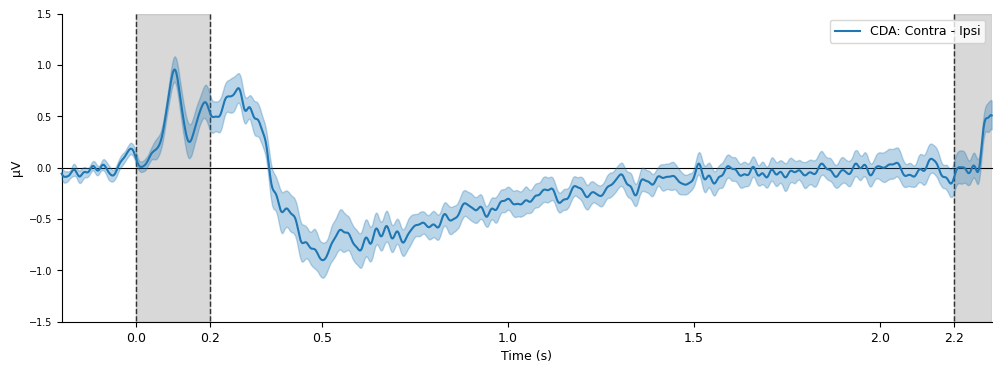

In [6]:

# Plot main CDA wave (grand-average across all conditions):
fig, ax = plt.subplots(1,1,figsize=(12,4))
plot_main_cda(ax, evokeds)
plt.show()

This looks pretty much as we would expect. We follow up with a "temporal
localizer" (Luck & Gaspelin, 2017) to find out for which time-window the CDA in
our data was signifiacantly different from 0. 

stat_fun(H1): min=-5.466396 max=5.243015
Running initial clustering
Found 5 clusters


/tmp/ipykernel_132945/3724257060.py:156: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  cluster_stats = permutation_cluster_1samp_test(


Permuting 9999 times...


/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
combining channels using "mean"


/tmp/ipykernel_132945/3724257060.py:211: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=0.0)


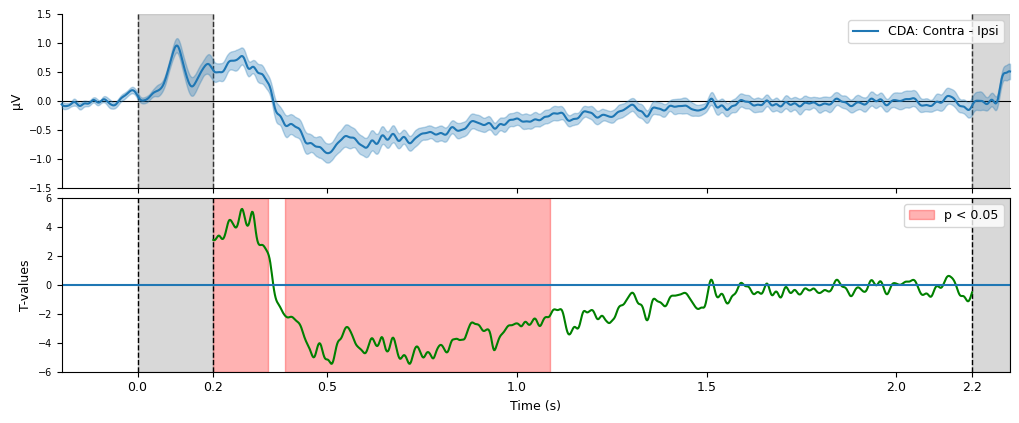

In [7]:
## Run cb-perm test to find intervall of interest:

# get data - cropped to retention interval:
times_full = evokeds['all'][0].times
c_list = [evo.copy().crop(config.times_dict['stim_dur'],
                          config.times_dict['stim_dur'] + config.times_dict['retention_dur'])
          for evo in evokeds['all']]
data = np.array([np.mean(c.data, axis=0) for c in c_list])
times_cbp = c_list[0].times
p_initial = 0.05
p_thresh = 0.05
n_perm = 10000
# run cbp test:
T_obs, clusters, cluster_p_values = run_cbp_test(data, p_initial=p_initial, p_thresh=p_thresh, n_perm=n_perm)

#TODO: check if the following line can be removed or replace by extraction of sign cluster times
# get times of strongest cluster:
# cluster_times, _ = find_largest_cluster_times(clusters, times_cbp)

# Plot the result:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True, constrained_layout=True)
plot_main_cda(axes[0], evokeds)
axes[0].xaxis.label.set_visible(False)
plot_cbp_result_cda(axes[1], T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full)

# Save it: 
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'ERP_lateralized_sign_clusters_cbp.png')
fig.savefig(fname, bbox_inches="tight")


We see two significant clusters: 
- 1 very early in the trial --> this is the PNP
- 1 a bit later --> this is the CDA

In [8]:
# get CDA times:
sign_cluster_idxs = np.where(cluster_p_values < p_thresh)[0]
# pick second sign. cluster
cda_times = times_cbp[clusters[sign_cluster_idxs[1]]]
cda_info_dict = {'cda_sign_cluster_t_start': cda_times[0] * 1000,
                 'cda_sign_cluster_t_end': cda_times[-1] * 1000,
                 'cda_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[1]]}

# Extract vars:
helpers.extract_var("cda_cbp_global_thresh_init", p_initial)
helpers.extract_var("cda_cbp_global_nperms", n_perm, exp_format=".0f")
helpers.extract_var("cda_cbp_2ndlvl_pval", p_thresh, is_pval=True)
for key in cda_info_dict:
    is_pval = "pval" in key
    helpers.extract_var(key, cda_info_dict[key], exp_format='.3f', is_pval=is_pval)

# get PNP times:
# pick first  sign. cluster
pnp_times = times_cbp[clusters[sign_cluster_idxs[0]]]
pnp_info_dict = {'pnp_sign_cluster_t_start': pnp_times[0] * 1000,
                 'pnp_sign_cluster_t_end': pnp_times[-1] * 1000,
                 'pnp_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[0]]}

# Extract vars:
for key in pnp_info_dict:
    is_pval = "pval" in key
    if is_pval:
        exp_format = '.3f'
    else:
        exp_format = '.0f'
    helpers.extract_var(key, pnp_info_dict[key], exp_format=exp_format, is_pval=is_pval)
    

### Save the mean amplitude data to CSV
To run statistics in R, we export mean amplitudes to CSV.
We do this twice:
1. for a fixed time window that we take from the literature (CDA: [Hakim et al., 2019](https://doi.org/10.1177/0956797619830384); PNP: [Papaioannou & Luck, 2020](https://doi.org/10.1111/psyp.13532)).
2. for a time window that we get in a data-driven fasion by running an agnostic cluster-based permutation test, identifying a time window where the difference wave is significantly different from 0 (across all conditions).

In [9]:
# CDA
## fixed time window:
dff = allsubjects_mean_amp_to_df(
    sub_list, "stimon", config.chans_CDA_dict["Left"], 0.45, 1.45, "CDA"
)
fpath = op.join(config.paths["04_evokeds-CDA"], "summaries", "fixed_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(
    sub_list,
    "stimon",
    config.chans_CDA_dict["Left"],
    cda_times[0],
    cda_times[-1],
    "CDA",
)
dff.groupby("c_StimN").mean()
fpath = op.join(config.paths["04_evokeds-CDA"], "summaries", "cluster_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

# PNP
## fixed time window:
dff = allsubjects_mean_amp_to_df(
    sub_list, "stimon", config.chans_CDA_dict["Left"], 0.300, 0.444, "PNP"
)
fpath = op.join(config.paths["04_evokeds-PNP"], "summaries", "fixed_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(
    sub_list,
    "stimon",
    config.chans_CDA_dict["Left"],
    pnp_times[0],
    pnp_times[-1],
    "PNP",
)
fpath = op.join(config.paths["04_evokeds-PNP"], "summaries", "cluster_times")
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")


Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_S15...
Reading VME_S16...
Reading VME_S17...
Reading VME_S18...
Reading VME_S20...
Reading VME_S21...
Reading VME_S23...
Reading VME_S24...
Reading VME_S25...
Reading VME_S26...
Reading VME_S27...
Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_S15...
Reading VME_S16...
Reading VME_S17...
Reading VME_S18...
Reading VME_S20...
Reading VME_S21...
Reading VME_S23...
Reading VME_S24...
Reading VME_S25...
Reading VME_S26...
Reading VME_S27...
Reading VME_S01...
Reading VME_S02...
Reading VME_S03...
Reading VME_S04...
Reading VME_S05...
Reading VME_S06...
Reading VME_S07...
Reading VME_S08...
Reading VME_S09...
Reading VME_S10...
Reading VME_

In the next steps, we plot the CDA as a function of the memory load and of the 
stimulus eccentricity:

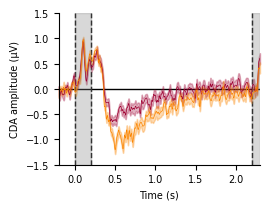

In [10]:
zoomfac = 1  # can be used to produce bigger plots (use 1 for publication)

cm = 1 / 2.54  # convert inch to cm
fig, ax = plt.subplots(1, 1, figsize=(6.6 * cm * zoomfac, 5 * cm * zoomfac))
picks = config.chans_CDA_dict["Left"]  # ['P5']  # ['PO3']  #
conds = ["LoadLow", "LoadHigh"]

# Our plotter function applies the Cousineau correction of the CI, but we need to tell it the number of factor levels:
def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=2, alpha=alpha)


ha = plot_main_effect(evokeds, conds, picks, ax, ci_func=ci_func, show_legend=False)

plt.show()

# Save it:
fpath = op.join(config.paths["plots"], "CDA", epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "mainEff_load.pdf")
fig.savefig(fname)  # , bbox_inches="tight")


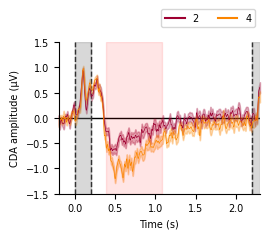

In [11]:
# And here overlaid with the region of the sign. cluster identified earlier by
# the "temporal localizer" method:
fig, ax = plt.subplots(1,1,figsize=(6.6*cm,5*cm))
plot_main_effect(evokeds, conds, picks, ax, sign_cluster=(cda_times[0], cda_times[-1]), ci_func=ci_func, show_legend=True)

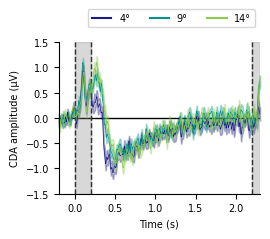

In [12]:
# plot main effect ecc: 
zoomfac = 1
fig, ax = plt.subplots(1,1,figsize=(6.6*cm*zoomfac,5*cm*zoomfac))

def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=3, alpha=alpha)
conds = ['EccS', 'EccM', 'EccL']
plot_main_effect(evokeds, conds, picks, ax, ci_func=ci_func, show_legend=True)


In [13]:

# Save it: 
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.pdf')
fig.savefig(fname, bbox_inches="tight")

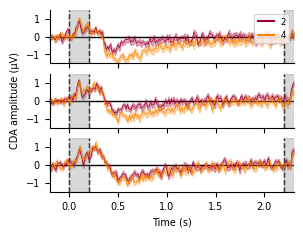

In [14]:
fig, axs = plt.subplots(3,1, figsize=(8*cm,6*cm))

# 
def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, n_factorlevels=2, alpha=alpha)
    # note that I am only correcting the SEMs for the 2 MemLoad levels, not for the eccentricity. Too much effort for a supplementary plot and anyways questionable to compare SEMs across subplots. Note that this only affects the visualization not the stat. results.
plot_interaction_eff(evokeds, picks, axs, ci_func, show_ecc=False)
plt.show()
# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'interaction_loadxecc.pdf')
fig.savefig(fname, bbox_inches="tight")

# Supplementary analyses

### 1. Does the chosen ROI (based on Hakim et al., 2015) reflect a strong CDA also in our data?

In [15]:
def plot_mean_cda_roi(mean_cda, ch_names_lat, ax, pal=None, scale=1.0, ytick_rot=65, ha='right'):
    sorted_w_idx = sorted([(v, i)
                          for i, v in enumerate(mean_cda.mean(axis=0))])
    idx_sorted = [i[1] for i in sorted_w_idx]

    idx_roi = [ch_names_lat.index(c) for c in config.chans_CDA_dict['Left']]

    cda_df = pd.DataFrame()

    cda_roi = np.mean(mean_cda[:, idx_roi], axis=-1)
    cda_df['our ROI'] = cda_roi
    cda_df['   '] = [-999] * len(mean_cda)

    our_roi_str = ['PO3/4', 'PO7/8', 'O1/2', 'P3/4', 'P5/6']

    n_rois = 20
    for i in range(n_rois):
        idx_sel = idx_sorted[:i+1]
        # cda_sel = np.mean(mean_cda[:,idx_sel], axis=-1)  # <-- plot mean for cumulative ROI
        cda_sel = mean_cda[:, idx_sel[-1]]  # <-- plot channels separately
        name = ch_names_lat[idx_sorted[i]] + '/' + \
            str(int(ch_names_lat[idx_sorted[i]][-1])+1)  # (i>0)*'+ ' +
        if name in our_roi_str:
            name += '*'
        cda_df[name] = cda_sel

    if pal is None:
        cols = list(sns.color_palette('viridis_r', n_rois+1))
        cols.insert(0, 'turquoise')  # cols[4])
        pal = {n: c for n, c in zip(cda_df.columns, cols)}
    else:
        pal_c = pal.copy()
        for cn in cda_df:
            comps = [p for p in pal_c if ((cn in p) or (p in cn))]
            if any(comps):
                pal[cn] = pal[comps[0]]
            else:
                pal[cn] = 'grey'

    # cda_df.boxplot(vert=False)
    val_name = f'mean CDA [+-1SEM] ({chr(956)}V)'
    ll = cda_df.melt(var_name='ROI', value_name=val_name)
    xx = list(range(10)) + [13]
    out = sns.pointplot(data=ll,
                        x='ROI',
                        y=val_name,
                        palette=pal,
                        errorbar='se',  # ('ci', 2),
                        dodge=True,
                        scale=scale,
                        errwidth=scale*3.5,
                        ax=ax)
    xticks = ax.get_xticks()
    xlabs = ax.get_xticklabels()
    ax.axhline(np.mean(cda_roi), color=pal['our ROI'], linestyle=':')
    ax.set_xticks(ticks=xticks, labels=xlabs, rotation=ytick_rot, ha=ha)
    ax.set_ylim(-0.8, 0.15)
    # ax.set_xlim(-0.6,0.2)

    return pal


In [16]:
# Load the evoked data:

from multiprocessing import Pool
from functools import partial

plt_dict_allchans = plt_dict.copy()
plt_dict_allchans['picks'] = []

# the following is the way faster but more cryptic version of:
# evokeds_allchans = get_evokeds_dict(sub_list, epo_part, plt_dict_allchans,
#                                     data_type="difference")

with Pool(len(sub_list)) as p:
    out = p.map(
        partial(
            get_evokeds_dict,
            epo_part=epo_part,
            plt_dict=plt_dict_allchans,
            data_type="difference",
        ),
        [[s] for s in sub_list]
    )
evokeds_allchans = {k : [d[k][0] for d in out] for d in out for k in d}

conds = ['all', 'EccS', 'EccM', 'EccL']
mean_cdas = dict()
for cond in conds: 
    cdas = np.asarray([c.copy().crop(0.4, 1.45).data for c in evokeds_allchans[cond]])
    mean_cdas[cond] = np.mean(cdas, axis=(-1)) * 1e6

ch_names_lat = evokeds_allchans['all'][0].ch_names

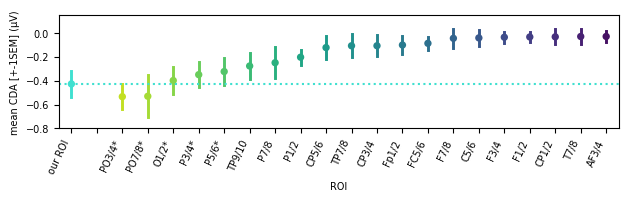

In [17]:
fig1, ax1 = plt.subplots(1,1, figsize=(16 * cm, 5 * cm))
pal = plot_mean_cda_roi(mean_cdas['all'], ch_names_lat=ch_names_lat, ax=ax1, scale=0.6)
fig1.tight_layout()

# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_ROIvsChans_allEcc.svg.pdf')
fig1.savefig(fname, bbox_inches="tight")


We see that our ROI (as taken from Hakim et al, 2019) is a pretty good representative of the channels with the strongest CDA.
Note that here we took the CDA time window [0.400 - 1.450] as suggested by Hakim et al. (2019) to not be biased towards our data.  

Especially, we will see that this pattern is fairly stable across all eccentricity conditions. Therefore, it is unlikely that there is an effect of eccentricity on the topography of the CDA.

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_132945/1879160115.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if cond is not 'EccS':


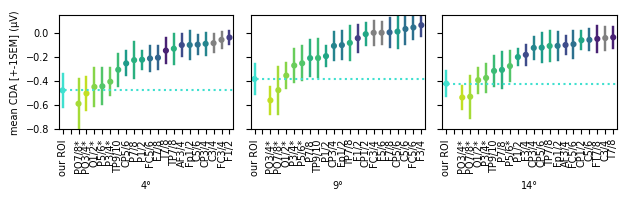

In [18]:

fig2, axes = plt.subplots(1,3, sharey=True, figsize=(16 * cm, 5 * cm))

conds_ecc = ['EccS', 'EccM', 'EccL']
for cond, ax in zip(conds_ecc, axes):
    plot_mean_cda_roi(mean_cda=mean_cdas[cond], ch_names_lat=ch_names_lat, ax=ax, pal=pal, scale=0.5, ytick_rot=90, ha='center') 
    ax.set_xlabel(config.labels[cond])
    if cond is not 'EccS':
        ax.set_ylabel('')
fig2.tight_layout()
# Save it:
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'CDA_ROIvsChans_perEcc.svg.pdf')
fig2.savefig(fname, bbox_inches="tight")

y-axis: mean CDA for a given ROI in the time-window [0.4; 1.45]s  
x-axis: left most is our ROI as adapted from Hakim et al. (2019): [PO3/4, PO7/8, O1/2, P3/4, P5/6];  
we compare it with ~~cumultive ROIs built by adding channel pairs one after the other,~~ the single channels sorted by (decreasing) CDA size.  
~~Note that the ROI which consists of the 5 channel pairs with the largest CDAs is identical to our ROI.~~  
Note that the color-to-channel matching is the same for each plot. Channels marked with * are constituents of our ROI.  
Importantly, this looks very similar across all eccentricity conditions. 
***  
~~This looks ok. Seems like the ROI we chose based on the literature is a good trade-off between a strong CDA and increasing SNR~~  
~~(or random fluctuations) by averaging over multiple channels (see how the SD decreases with the rising numbers of channels in the ROI).~~  

Importantly, 

We follow this up by another data-driven approach: we run a CBP test on the CDA-difference between the high and low memory load condition.  
This time we let the test determine clusters over time and channels. If we find a significant cluster, we can check whether its channels are congruent with our a priori choice:

In [19]:
times = evokeds_allchans['all'][0].times
chan_adj, ch_n = mne.channels.find_ch_adjacency(evokeds_allchans['all'][0].info, 'eeg')
adj_overall = mne.stats.combine_adjacency(chan_adj, len(times))

c_list_low = np.array([evo.data for evo in evokeds_allchans['LoadLow']])
c_list_high = np.array([evo.data for evo in evokeds_allchans['LoadHigh']])
data = c_list_high - c_list_low
T_obs, clusters, cluster_pvals = run_cbp_test(data, adjacency=adj_overall, n_perm=10e3)
sign_clusters = np.array(clusters)[cluster_pvals < 0.05]
print(f'Number of sign. clusters: {len(sign_clusters)}')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 26
stat_fun(H1): min=-7.092375 max=4.024186
Running initial clustering
Found 108 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Number of sign. clusters: 1


/tmp/ipykernel_132945/1692893331.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sign_clusters = np.array(clusters)[cluster_pvals < 0.05]


In [20]:
dd = plt_dict.copy()
dd['picks'] = None
#haha = get_evokeds_dict(sub_list, epo_part, dd, data_type="difference")
with Pool(len(sub_list)) as p:
    out = p.map(
        partial(
            get_evokeds_dict,
            epo_part=epo_part,
            plt_dict=plt_dict_allchans,
            data_type="difference",
        ),
        [[s] for s in sub_list]
    )
haha = {k : [d[k][0] for d in out] for d in out for k in d}


In [21]:
ha = haha['all'][0].copy()
easycap_montage = mne.channels.make_standard_montage('easycap-M1')
ha.set_montage(easycap_montage)
#mne.viz.plot_sensors(evokeds_allchans['all'][0].info, show_names=True)


<Evoked | '0.04 × Stimulus/S150 + 0.04 × Stimulus/S151 + 0.04 × Stimulus/S152 + 0.04 × Stimulus/S153 + 0.04 × Stimulus/S154 + 0.04 × Stimulus/S155 + 0.04 × Stimulus/S156 + 0.04 × Stimulus/S157 + 0.04 × Stimulus/S158 + 0.04 × Stimulus/S159 + 0.04 × Stimulus/S160 + 0.04 × Stimulus/S161 + 0.04 × Stimulus/S162 + 0.04 × Stimulus/S163 + 0.04 × Stimulus/S164 + 0.04 × Stimulus/S165 + 0.04 × Stimulus/S166 + 0.04 × Stimulus/S167 + 0.04 × Stimulus/S168 + 0.04 × Stimulus/S169 + 0.04 × Stimulus/S170 + 0.04 × Stimulus/S171 + 0.04 × Stimulus/S172 + 0.04 × Stimulus/S173' (average, N=684), -0.2 – 2.3 sec, baseline off, 26 ch, ~298 kB>

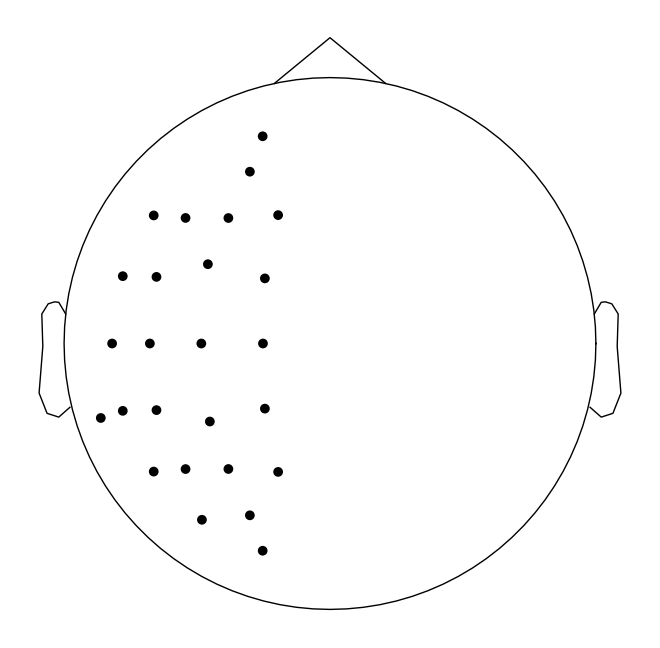

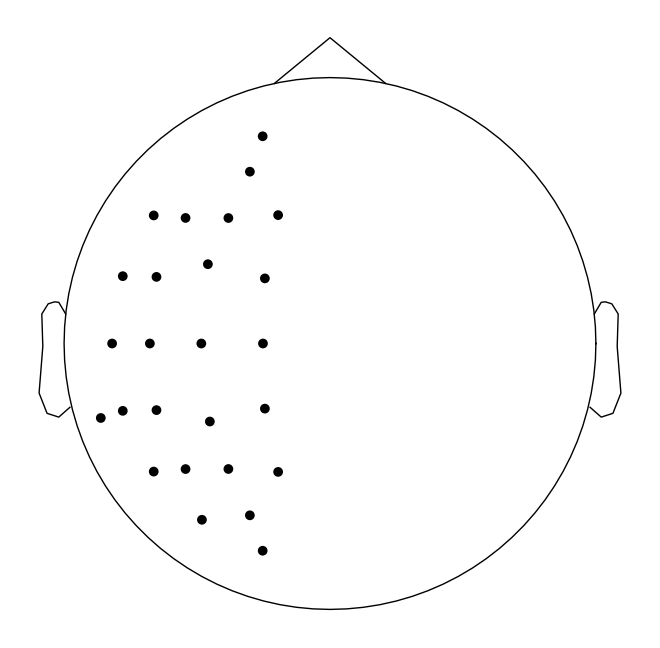

In [22]:
ha.plot_sensors()

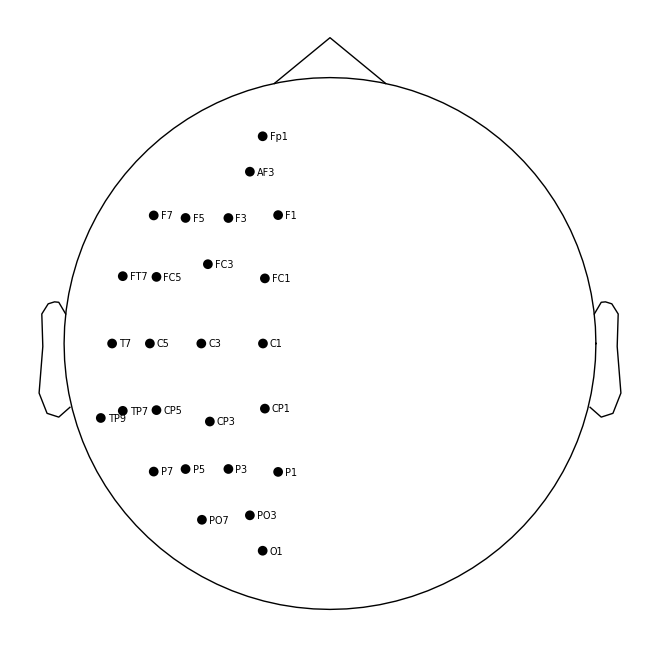

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 26


In [23]:
ha.plot_sensors(show_names=True)
chan_adj, ch_n = mne.channels.find_ch_adjacency(ha.info, 'eeg')
adj_overall = mne.stats.combine_adjacency(chan_adj, len(times))

[Text(0, 0, 'O1'),
 Text(0, 1, 'PO7'),
 Text(0, 2, 'PO3'),
 Text(0, 3, 'P7'),
 Text(0, 4, 'P5'),
 Text(0, 5, 'P3'),
 Text(0, 6, 'P1'),
 Text(0, 7, 'TP9'),
 Text(0, 8, 'TP7'),
 Text(0, 9, 'CP5'),
 Text(0, 10, 'CP3'),
 Text(0, 11, 'CP1'),
 Text(0, 12, 'C5'),
 Text(0, 13, 'T7'),
 Text(0, 14, 'C3'),
 Text(0, 15, 'C1'),
 Text(0, 16, 'FC1'),
 Text(0, 17, 'FC3'),
 Text(0, 18, 'FC5'),
 Text(0, 19, 'FT7'),
 Text(0, 20, 'F1'),
 Text(0, 21, 'F3'),
 Text(0, 22, 'F5'),
 Text(0, 23, 'F7'),
 Text(0, 24, 'AF3'),
 Text(0, 25, 'Fp1')]

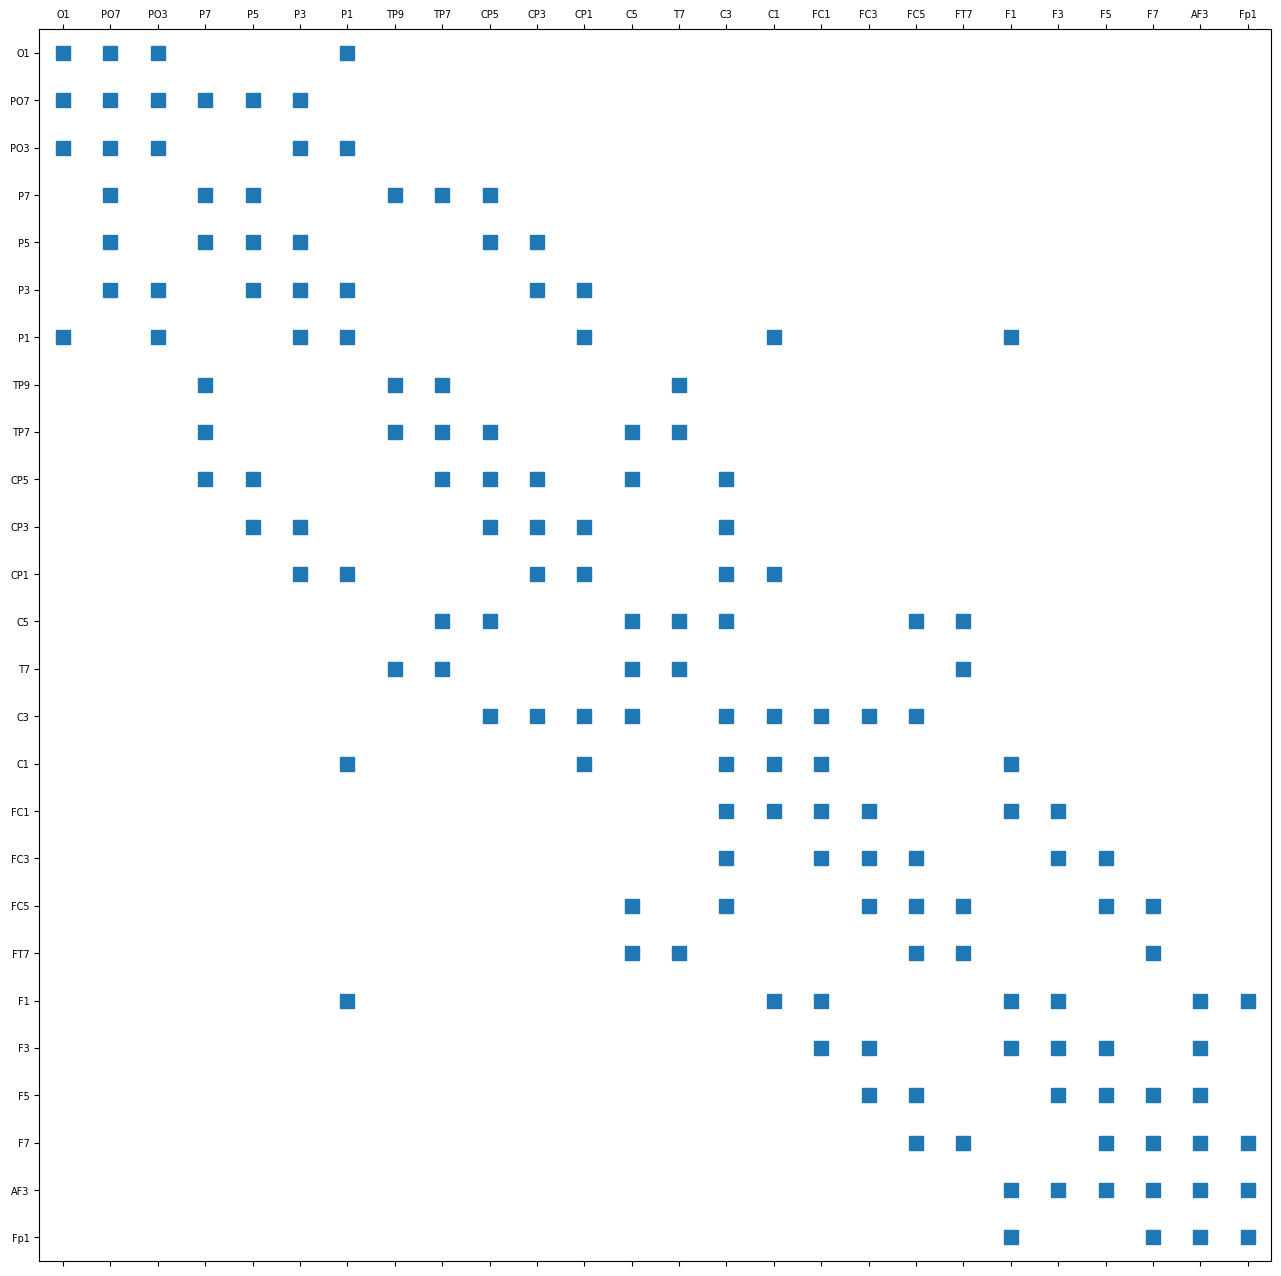

In [24]:
fig, ax = plt.subplots(figsize=(16,16))
ax.spy(chan_adj)
ax.set_xticks(range(len(ch_n)))
ax.set_xticklabels(ch_n)
ax.set_yticks(range(len(ch_n)))
ax.set_yticklabels(ch_n)

We find only 1 sign. cluster. Let's check in which time window and which channels: 

In [25]:
sign_chans = sign_clusters[0][0]
sign_times = sign_clusters[0][1]
print(f'Time start: {np.min(times[sign_times])} s')
print(f'Time end  : {np.max(times[sign_times])} s')
print(f'Channels: {set(np.array(ch_names_lat)[sign_chans])}')

Time start: 0.356 s
Time end  : 0.904 s
Channels: {'CP3', 'CP5', 'P3', 'FC5', 'FC1', 'FC3', 'TP9', 'C5', 'F7', 'TP7', 'T7', 'O1', 'P7', 'C3', 'P5', 'P1', 'PO3', 'PO7', 'CP1'}


The test seems to be fairly sensitive in regards of channels and includes plenty of them. However, our ROI is also fully included.  
Now, to check for effects of eccentricity, we run a similar test, but this time also checking for the main effect of Eccentricity and its interaction with the main effect of Load: 

/tmp/ipykernel_132945/3922415491.py:9: RuntimeWarning: Channel(s) ['P4', 'P6', 'PO4', 'PO8', 'O2'] could not be picked, because they are not present in the info instance.
  df_list.extend([np.mean(d.copy().pick(config.chans_CDA_all).data, axis=0, keepdims=True) for d in diffs_])
/tmp/ipykernel_132945/3922415491.py:9: RuntimeWarning: Channel(s) ['P4', 'P6', 'PO4', 'PO8', 'O2'] could not be picked, because they are not present in the info instance.
  df_list.extend([np.mean(d.copy().pick(config.chans_CDA_all).data, axis=0, keepdims=True) for d in diffs_])
/tmp/ipykernel_132945/3922415491.py:9: RuntimeWarning: Channel(s) ['P4', 'P6', 'PO4', 'PO8', 'O2'] could not be picked, because they are not present in the info instance.
  df_list.extend([np.mean(d.copy().pick(config.chans_CDA_all).data, axis=0, keepdims=True) for d in diffs_])
/tmp/ipykernel_132945/3922415491.py:9: RuntimeWarning: Channel(s) ['P4', 'P6', 'PO4', 'PO8', 'O2'] could not be picked, because they are not present in the info

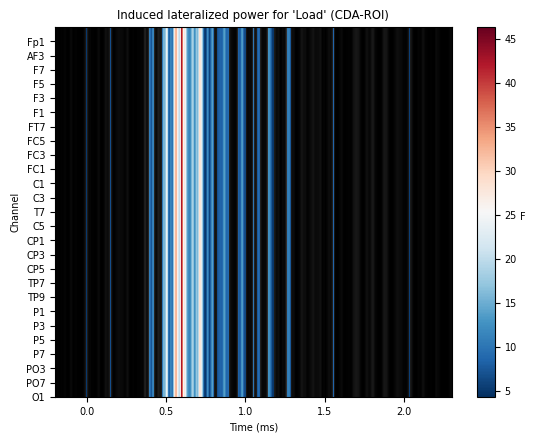

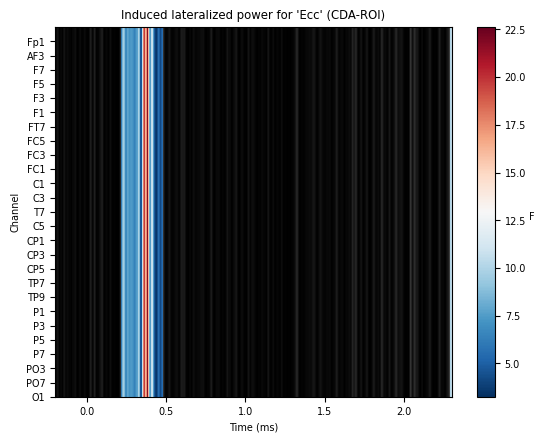

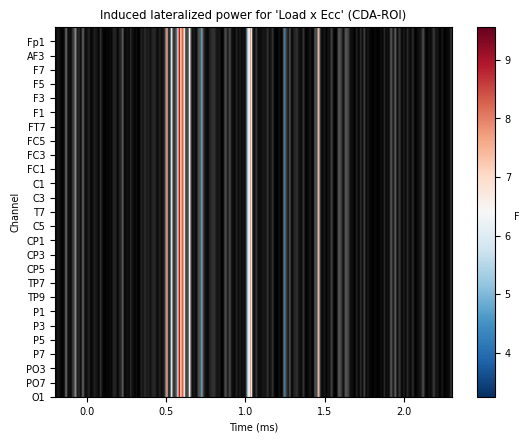

In [26]:
from mne.stats import f_mway_rm, f_threshold_mway_rm

cond_dict = {"Load": ["LoadLow", "LoadHigh"], "Ecc": ["EccS", "EccM", "EccL"]}
df_list = list()
for load in cond_dict["Load"]:
    for ecc in cond_dict["Ecc"]:

        diffs_ = evokeds_allchans[load + ecc]
        df_list.extend([np.mean(d.copy().pick(config.chans_CDA_all).data, axis=0, keepdims=True) for d in diffs_])
    times = diffs_[0].times
    ch_names = diffs_[0].ch_names

# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = "A*B"
n_levels = np.multiply(*factor_levels)
n_chans = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)


# Shape data matrix: subjects x effects x n_channels*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_chans * n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)
effect_labels = ["Load", "Ecc", "Load x Ecc"]
# Plot result:
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    f = plt.figure()
    # show naive F-values in gray
    plt.imshow(
        effect.reshape(n_chans, n_times),
        cmap=plt.cm.gray,
        extent=[times[0], times[-1], 0, len(ch_names)],
        aspect="auto",
        origin="lower",
    )
    # create mask for significant Time-frequency locations
    effect[sig >= 0.05] = np.nan
    plt.imshow(
        effect.reshape(n_chans, n_times),
        cmap="RdBu_r",
        extent=[times[0], times[-1], 0, len(ch_names)],
        aspect="auto",
        origin="lower",
    )
    cb = plt.colorbar()
    cb.set_label(label="F", rotation=0)
    f.axes[0].set_yticks(range(len(ch_names)))
    f.axes[0].set_yticklabels(ch_names)
    plt.xlabel("Time (ms)")
    plt.ylabel("Channel")
    plt.title(r"Induced lateralized power for '%s' (%s)" % (effect_label, "CDA-ROI"))
    plt.show()


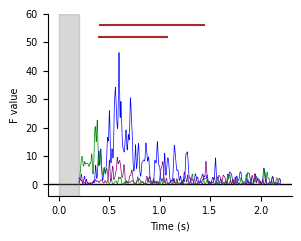

In [27]:
from mne.stats import f_mway_rm, f_threshold_mway_rm

cond_dict = {"Load": ["LoadLow", "LoadHigh"], "Ecc": ["EccS", "EccM", "EccL"]}
df_list = list()
for load in cond_dict["Load"]:
    for ecc in cond_dict["Ecc"]:

        diffs_ = evokeds_allchans[load + ecc]
        df_list.extend([np.mean(d.copy().pick(config.chans_CDA_dict['Contra']).data, axis=0, keepdims=True) for d in diffs_])
    times = diffs_[0].times
    ch_names = diffs_[0].ch_names

# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = "A*B"
n_levels = np.multiply(*factor_levels)
n_chans = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)


# Shape data matrix: subjects x effects x n_channels*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_chans * n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)

# crop to retention interrval:
t_start = np.where(times == 0.2)[0]
t_end = np.where(times == 2.2)[0]
fvals = fvals[:, t_start[0]:t_end[0]]
times_ret = times[t_start[0]:t_end[0]]

fig, ax = plt.subplots(1, figsize=(8 * cm, 6 * cm))
ax.plot(times_ret, fvals.T, linewidth=0.5)
colors = ('blue', 'green', 'purple')
labels = ('main effect: memory load', 'main effect: eccentricity', 
          'interaction effect: memory load x eccentricity')
for c, l in zip(colors, ax.lines):
    l.set_color(c)
    l.set_label(l)
ax.set_ylim(-4, 60)
ax.set_ylabel("F value")
ax.set_xlabel("Time (s)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='k', linewidth=1., zorder=-2)
ax.axvspan(0, 0.2, color='grey', alpha=0.3)

# original time window:
ax.hlines(
    52,
    xmin=cda_times[0],
    xmax=cda_times[-1],
    color='brown',
    label='original CDA time-window',
)

# alternative time window:
ax.hlines(
    56,
    xmin=0.4,
    xmax=1.45,
    color='brown',
    label='original CDA time-window',
)

# Save it:
fpath = op.join(config.paths["plots"], "CDA", epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "ANOVA_effects.pdf")
fig.savefig(fname, bbox_inches="tight")

In [28]:
t_start

array([200])

Let's correct these for multiple comparisons (change the effect manually):

stat_fun(H1): min=0.000002 max=46.367399
Running initial clustering
Found 16 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


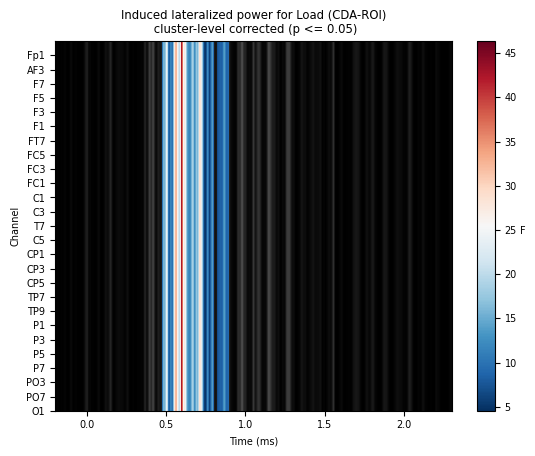

stat_fun(H1): min=0.000629 max=22.620445
Running initial clustering
Found 9 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


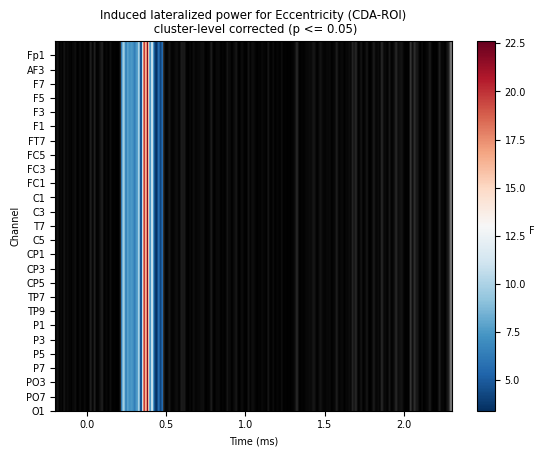

stat_fun(H1): min=0.000885 max=9.559631
Running initial clustering
Found 14 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


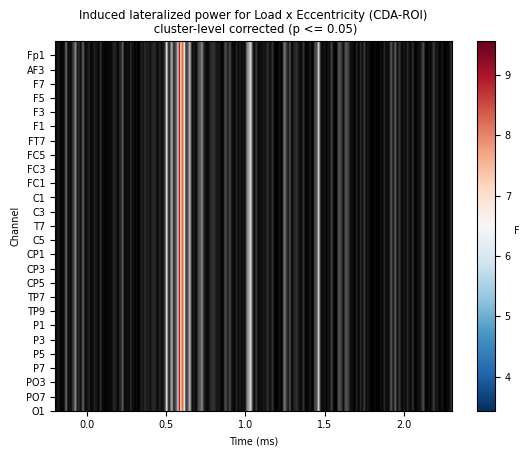

In [29]:
# Use CBP test to correct for multiple-comparisons correction:

# We need to do this separately for each effect:
effects = ["A", "B", "A:B"]

for effect in effects:

    effects_dict = {"A": "Load", "B": "Eccentricity", "A:B": "Load x Eccentricity"}

    def stat_fun(*args):
        return f_mway_rm(
            np.reshape(args, (len(sub_list), n_levels, n_chans, len(times))),
            factor_levels=factor_levels,
            effects=effect,
            return_pvals=False,
        )[0]

    # The ANOVA returns a tuple f-values and p-values, we will pick the former.
    pthresh = 0.05  # set threshold rather high to save some time
    f_thresh = f_threshold_mway_rm(len(sub_list), factor_levels, effect, pthresh)
    tail = 1  # f-test, so tail > 0
    n_permutations = 10000  # Save some time (the test won't be too sensitive ...)
    T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
        subtfr_mway_data,
        stat_fun=stat_fun,
        threshold=f_thresh,
        tail=tail,
        n_jobs=-2,
        n_permutations=n_permutations,
        # adjacency=adj_overall,
        buffer_size=None,
        out_type="mask",
    )

    # Plot it:
    T_obs_plot = np.ones_like(T_obs) * np.nan
    for c, p in zip(clusters, cluster_p_values):
        if p < 0.05:
            T_obs_plot[c] = T_obs[c]

    f = plt.figure()
    for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, "RdBu_r"]):
        plt.imshow(
            f_image.reshape(n_chans, n_times),
            cmap=cmap,
            extent=[times[0], times[-1], 0, len(ch_names)],
            aspect="auto",
            origin="lower",
        )
    cb = plt.colorbar()
    cb.set_label(label="F", rotation=0)
    f.axes[0].set_yticks(range(len(ch_names)))
    f.axes[0].set_yticklabels(ch_names)
    plt.xlabel("Time (ms)")
    plt.ylabel("Channel")
    plt.title(
        f"Induced lateralized power for {effects_dict[effect]} (%s)\n"
        " cluster-level corrected (p <= 0.05)" % "CDA-ROI"
    )

    plt.show()


In [30]:
np.any(cluster_p_values < 0.05)

True

This confirms that there is no interaction between eccentricity and the memory load effect in any channel, despite we see main effects. These, however, barely overlap in time. That is, again, the earlier PNP is affected by eccentricity (but not by memory load) while the later CDA is affected by memory load (and not by eccentricity). 

In [31]:
# Post-hoc CBP t-test per ecc

ecc = ""
conds_ecc = ["EccS", "EccM", "EccL"]
for ecc in conds_ecc:

    evo_low = np.array([e.data for e in evokeds_allchans["LoadLow" + ecc]])
    evo_high = np.array([e.data for e in evokeds_allchans["LoadHigh" + ecc]])

    evo_diff = evo_high - evo_low

    evo_diff = evo_diff.swapaxes(2, 1)

    times = evokeds_allchans["all"][0].times
    chan_adj, ch_n = mne.channels.find_ch_adjacency(
        evokeds_allchans["all"][0].info, "eeg"
    )
    adj_overall_ts = mne.stats.combine_adjacency(len(times), chan_adj)
    (
        T_obs,
        clusters,
        cluster_p_values,
        h0,
    ) = mne.stats.spatio_temporal_cluster_1samp_test(
        evo_diff, adjacency=adj_overall_ts, n_jobs=-2, n_permutations=10e3
    )
    T_obs_orig = T_obs.copy()
    clusters_orig = clusters.copy()
    T_obs = np.transpose(T_obs)
    clusters = [np.array([c[1], c[0]]) for c in clusters]
    # Plot it:
    T_obs_plot = np.ones_like(T_obs) * np.nan
    for c, p in zip(clusters, cluster_p_values):
        if p < 0.05:
            T_obs_plot[c[0], c[1]] = T_obs[c[0], c[1]]

    f = plt.figure()
    for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, "RdBu_r"]):
        plt.imshow(
            f_image.reshape(n_chans, n_times),
            vmin=-5,
            vmax=5,
            cmap=cmap,
            extent=[times[0], times[-1], 0, len(ch_names)],
            aspect="auto",
            origin="lower",
        )
    cb = plt.colorbar()
    cb.set_label(label="T", rotation=0)
    f.axes[0].set_yticks([y + 0.5 for y in range(len(ch_names))])
    f.axes[0].set_yticklabels(ch_names)
    plt.xlabel("Time (ms)")
    plt.ylabel("Channel")
    plt.title(
        f"Difference in CDA for eccentricity {config.labels[ecc]}\n"
        " cluster-level corrected (p <= 0.05)"
    )

    plt.show()


Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 26
Using a threshold of 2.085963
stat_fun(H1): min=-7.262712 max=3.499343
Running initial clustering
Found 123 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


ValueError: cannot reshape array of size 32526 into shape (1,1251)

<Figure size 640x480 with 0 Axes>

Also this confirms what we have seen in the ROI-based analysis: for the largest eccentricity we do not find a significant load effect, but there is nevertheless also no sign. interaction between load and eccentricity effects.